# CropperHead
A project to build a machine learning model which can be trained to crop images automatically. Generally:

Input:
- Photo(s)
Output:
- vector of four [`Crop Top`, `Crop Left`, `Crop Bottom`, `Crop Right`, `Crop Angle`]

For training, we are using images edited with Adobe Lightroom. The training data is extracted from the image `exif`-data. 

**NOTE**
>Additional edits can be added later.

## 1. Setup
### 1.1. Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import os
import glob
import json
import ntpath

from tqdm.notebook import tqdm
from importlib import reload

import tensorflow as tf
import ipywidgets as widgets
from IPython import display as displayer

In [2]:
import plot_utils as put
put = reload(put)

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

### 1.2. Directory parameters
Place the data within the folders defined below.

In [8]:
# Directory with raw training data:
dir_data = 'data/'

# Destination directory for the results:
dir_train = dir_data+'train/'
dir_eval = dir_data+'eval/'

dir_save = 'models/'
dir_cp = 'checkpoints/'

In [9]:
# Create the missing directories:
for d in [dir_data, dir_train, dir_eval, dir_save, dir_cp]:
    if not os.path.isdir(d):
        os.makedirs(d)

---
## 2. Preparing the training data
To use some of the readily available models, we need to do some preprocessing for our photos; namely:

1. Extract the crop (and other) data
2. Export a smaller version of the image
3. Convert the crop data into json annotation

### 2.1 Load the crop data
The data is created using `ExifAnnotator`. It creates resized jpg images from orignal size images, ans lists their properties into a annotation (`json`) file. The images location should be relative to the annotation file. Multiple annotations files and repsective image folders can be used.

In [12]:
# Define the annotation files:
label_files = [
    'anno_norway.json',
    'anno_mexico.json',
]

# Load data and create dataframe:
annotations = []
for label_file in label_files:
    with open(dir_data+label_file, 'r') as f:
        annotations += json.load(f)
df = pd.DataFrame(annotations)

# Create a column with a full relative path to the photos:
df['FullImgPath'] = dir_train+df.FileName

print("Total available Images:", df.shape[0])
display(df.head())
display(df.describe())


Total available Images: 258


,ImageWidth,ImageHeight,CropTop,CropLeft,CropBottom,CropRight,CropAngle,Orientation,Original,ExifFileName,...,CropFactor,PhotoFileName,FileName,dest_dir,dim_max,height,width,quality,dir,FullImgPath
0,NaN,NaN,0.126120,0.017736,1.000000,0.980742,1.043790,1,None,_ORN4025.xmp,...,0.040779,_ORN4025.NEF,_ORN4025.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4025.jpg
1,NaN,NaN,0.310777,0.013278,0.889724,0.558506,0.000000,1,None,_ORN4056.xmp,...,0.218956,_ORN4056.NEF,_ORN4056.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4056.jpg
2,NaN,NaN,0.115861,0.072567,0.957168,0.937328,0.000000,1,None,_ORN4094.xmp,...,0.073483,_ORN4094.NEF,_ORN4094.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4094.jpg
3,NaN,NaN,0.100250,0.000000,0.862155,0.759336,0.000000,1,None,_ORN4097.xmp,...,0.119690,_ORN4097.NEF,_ORN4097.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4097.jpg
4,NaN,NaN,0.000000,0.016858,1.000000,0.983142,0.910585,1,None,_ORN4103.xmp,...,0.008429,_ORN4103.NEF,_ORN4103.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4103.jpg


,ImageWidth,ImageHeight,CropTop,CropLeft,CropBottom,CropRight,CropAngle,Orientation,CropFactor,dim_max,height,width,quality
count,169.000000,169.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0,258.0,258.0,258.0
mean,4927.834320,3299.313609,0.105248,0.036277,0.926523,0.964719,0.064173,1.670543,0.062571,640.0,640.0,320.0,80.0
std,182.635914,178.773606,0.090748,0.084111,0.093767,0.082969,1.095229,2.054696,0.046198,0.0,0.0,0.0,0.0
min,3264.000000,3264.000000,0.000000,0.000000,0.518152,0.535270,-9.622530,1.000000,0.004798,640.0,640.0,320.0,80.0
25%,4948.000000,3280.000000,0.029785,0.000000,0.889792,0.982348,0.000000,1.000000,0.034088,640.0,640.0,320.0,80.0
50%,4948.000000,3280.000000,0.090756,0.000000,0.959661,1.000000,0.000000,1.000000,0.049835,640.0,640.0,320.0,80.0
75%,4948.000000,3280.000000,0.158625,0.019905,1.000000,1.000000,0.000000,1.000000,0.073339,640.0,640.0,320.0,80.0
max,4948.000000,4928.000000,0.446786,0.426608,1.000000,1.000000,9.457040,8.000000,0.286184,640.0,640.0,320.0,80.0


In [13]:
# Define the values we want to learn:
features_to_learn = [
    "CropTop",
    "CropLeft",
    "CropBottom",
    "CropRight",
    "CropAngle",
]

file_path_col = 'FullImgPath'

In [14]:
# HACK: Shift the values from [0,1] to [-1,1]:
val_shift = lambda x: x*2-1
val_shift_inv = lambda x: (x+1)/2

for f in ["CropTop", "CropLeft", "CropBottom", "CropRight"]:
    df[f] = df[f].apply(val_shift)

In [15]:
display(df.head())
display(df.describe())

,ImageWidth,ImageHeight,CropTop,CropLeft,CropBottom,CropRight,CropAngle,Orientation,Original,ExifFileName,...,CropFactor,PhotoFileName,FileName,dest_dir,dim_max,height,width,quality,dir,FullImgPath
0,NaN,NaN,-0.747760,-0.964528,1.000000,0.961484,1.043790,1,None,_ORN4025.xmp,...,0.040779,_ORN4025.NEF,_ORN4025.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4025.jpg
1,NaN,NaN,-0.378446,-0.973444,0.779448,0.117012,0.000000,1,None,_ORN4056.xmp,...,0.218956,_ORN4056.NEF,_ORN4056.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4056.jpg
2,NaN,NaN,-0.768278,-0.854866,0.914336,0.874656,0.000000,1,None,_ORN4094.xmp,...,0.073483,_ORN4094.NEF,_ORN4094.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4094.jpg
3,NaN,NaN,-0.799500,-1.000000,0.724310,0.518672,0.000000,1,None,_ORN4097.xmp,...,0.119690,_ORN4097.NEF,_ORN4097.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4097.jpg
4,NaN,NaN,-1.000000,-0.966284,1.000000,0.966284,0.910585,1,None,_ORN4103.xmp,...,0.008429,_ORN4103.NEF,_ORN4103.jpg,resized/,640,640,320,80,S:/128D7000,data/train/_ORN4103.jpg


,ImageWidth,ImageHeight,CropTop,CropLeft,CropBottom,CropRight,CropAngle,Orientation,CropFactor,dim_max,height,width,quality
count,169.000000,169.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0,258.0,258.0,258.0
mean,4927.834320,3299.313609,-0.789505,-0.927446,0.853046,0.929438,0.064173,1.670543,0.062571,640.0,640.0,320.0,80.0
std,182.635914,178.773606,0.181496,0.168222,0.187534,0.165939,1.095229,2.054696,0.046198,0.0,0.0,0.0,0.0
min,3264.000000,3264.000000,-1.000000,-1.000000,0.036304,0.070540,-9.622530,1.000000,0.004798,640.0,640.0,320.0,80.0
25%,4948.000000,3280.000000,-0.940431,-1.000000,0.779585,0.964696,0.000000,1.000000,0.034088,640.0,640.0,320.0,80.0
50%,4948.000000,3280.000000,-0.818488,-1.000000,0.919321,1.000000,0.000000,1.000000,0.049835,640.0,640.0,320.0,80.0
75%,4948.000000,3280.000000,-0.682751,-0.960190,1.000000,1.000000,0.000000,1.000000,0.073339,640.0,640.0,320.0,80.0
max,4948.000000,4928.000000,-0.106428,-0.146784,1.000000,1.000000,9.457040,8.000000,0.286184,640.0,640.0,320.0,80.0


---
### 2.2 Inspect the value distributions

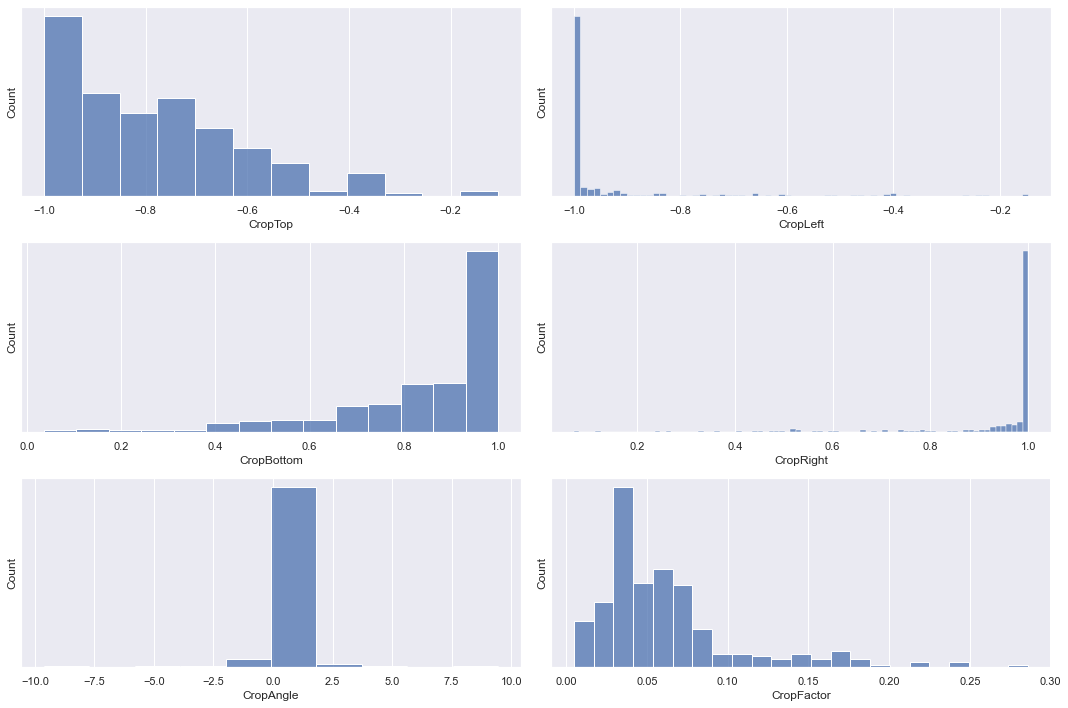

In [16]:
sns.set_theme(style="darkgrid")
f, axes = plt.subplots(3, 2)
# sns.despine(left=True)

sns.histplot(df, x="CropTop", ax=axes[0, 0])
sns.histplot(df, x="CropLeft", ax=axes[0, 1])
sns.histplot(df, x="CropBottom", ax=axes[1, 0])
sns.histplot(df, x="CropRight", ax=axes[1, 1])
sns.histplot(df, x="CropAngle", ax=axes[2, 0])
sns.histplot(df, x="CropFactor", ax=axes[2, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()

### 2.3 On data set size and data augmentation
From the distributions, we can see that I have not been cropping images that much in the vertical direction (*CropTop* and *CropBottom* heavily slanted on |-1|) but even more so in the horizontal direction (*CropLeft* and *CropRight* heavily slanted on |-1|)

This will probably lead to the model preferring crops near top left and bottom right corners. On one hand, this is simply the nature and reflective to my style of cropping, but might not consider the image and its contents as much. 

Therefore, we have two options, along with acquiring new data: to remove most extreme cases of crops (especially in the horizontal direction), or augment data someho,to balance the distributions.

As our dataset is already rather limited, we will try data augmentation.

Hyphotetically, as the vertical crops are relatively better distributed, rotating images 90 degrees CW or CCW should be effective. Additionally, flipping images should also provide us with more data and hence improve the model.

---

Considering that we do data augmentation in the following way:
- Rotate images 90°, 180° or 270°
- Flip image horizontally
- Flip image Vertically

These will change the crop values, and hence hopefully remove a bit of the statistical prediction

Additionally, to mess around with the input data, we do randomly N of the following:
- Blur them image
- Sharpen the image
- Emboss the image
- Add Gaussian noise
- Remove random pixels
- Invert colour channels
- Add brightness
- Add hue and saturation
- Small elastic transform
- Small affine transform
- Small perspective transform

These augmentations are built in to our custom DataGenerator so we can not get exact effects and distributions, but we can simulate their effects by Monte Carlo:


In [17]:
p_rot = 0.5
p_flipV = 0.5
p_flipH = 0
p_other = 0

def rotate90(data):
#     print("DATDA", data)
    n = int(np.random.rand(1)[0] // 0.3333333 + 1)
    data = [data[(n)%4], data[(n+1)%4], data[(n+2)%4], data[(n+3)%4]]
    
    invarr = [[1, -1, 1, -1], [-1, -1, -1, -1], [-1, 1, -1, 1]][n-1]
    return [invarr[i]*data[i] for i in range(4)]

def flipH(data):
#     print("DATDA", data)
    return [data[0], -data[3], data[2], -data[1]]

def flipV(data):
#     print("DATDA", data)
    return [-data[2], data[1], -data[0], data[3]]

def sometimes(data, p, func, **kwargs):
    if np.random.rand(1)[0] < p:
        return func(data, **kwargs)
    return data

# Super inefficient but simple:
# Assumiing that steps_per_epoch === len(data)/batch_size
def augment(data, epochs):
    n_data = data.shape[0]
             
    aug = np.empty((n_data*epochs, 4))
    for e in range(epochs):
        for i in range(n_data):
            data[i] = sometimes(data[i], p_rot, rotate90)
            data[i] = sometimes(data[i], p_flipH, flipH)
            data[i] = sometimes(data[i], p_flipV, flipV)
            
            aug[e*n_data + i, :] = data[i]
    
    return aug


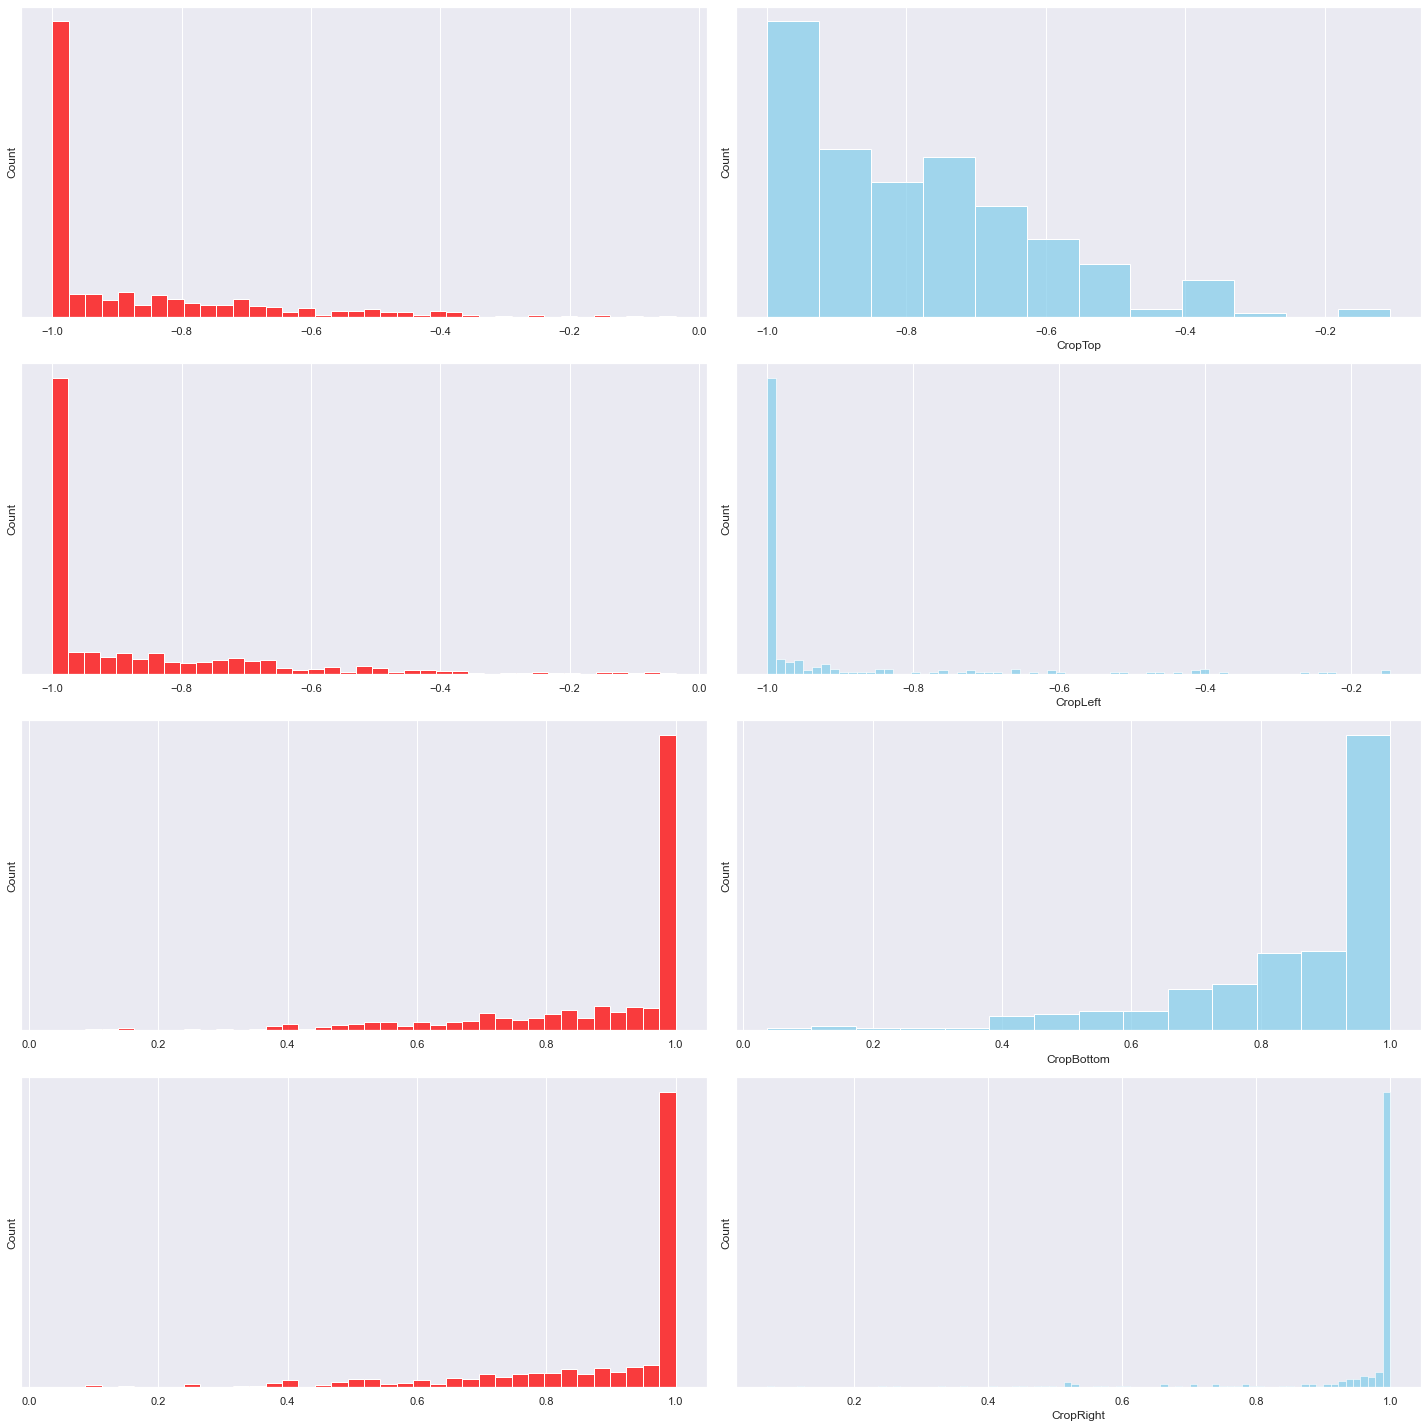

In [44]:
# Form the label matrix: (angle ignored)
data_aug = augment(df[['CropTop','CropLeft', 'CropBottom', 'CropRight']].to_numpy(), epochs=15)

sns.set_theme(style="darkgrid")
f, axes = plt.subplots(4, 2, figsize=(20,20))

sns.histplot(data_aug[:,0], ax=axes[0, 0], color="red")
sns.histplot(data_aug[:,1], ax=axes[1, 0], color="red")
sns.histplot(data_aug[:,2], ax=axes[2, 0], color="red")
sns.histplot(data_aug[:,3], ax=axes[3, 0], color="red")

sns.histplot(df["CropTop"],    ax=axes[0, 1], color="skyblue")
sns.histplot(df["CropLeft"],   ax=axes[1, 1], color="skyblue")
sns.histplot(df["CropBottom"], ax=axes[2, 1], color="skyblue")
sns.histplot(df["CropRight"],  ax=axes[3, 1], color="skyblue")

plt.setp(axes, yticks=[])
plt.tight_layout()

## 3. Load the image data (optionally with augmentation):

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
import image_augmenter as ia
ia = reload(ia)

In [21]:
BATCH_SIZE = 15
IMG_HEIGHT = 300
IMG_WIDTH = 300
AUGMENT = False

In [22]:
# Loads data into generator object(s)
if AUGMENT:  # Use cusomt generator with data augmentation:
    df_train, df_test = train_test_split(df, test_size=0.1)

    train_data_gen = ia.CropDataGenerator(df_train, "FullImgPath", "CropTop", "CropLeft", 
                                       "CropBottom", "CropRight", "CropAngle", dim=IMG_HEIGHT, 
                                       batch_size=BATCH_SIZE, as_floats=True, augment=True)
    eval_data_gen = ia.CropDataGenerator(df_test, "FullImgPath", "CropTop", "CropLeft",
                                      "CropBottom", "CropRight", "CropAngle", dim=IMG_HEIGHT, 
                                      batch_size=BATCH_SIZE, as_floats=True, augment=False)

    
else:  # Use Keras Data generator (no augmentation):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.10
    )
    
    train_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                         directory='.',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='raw',
                                                         x_col=file_path_col,
                                                         y_col=features_to_learn,
                                                         subset='training')

    eval_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                         directory='.',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='raw',
                                                         x_col=file_path_col,
                                                         y_col=features_to_learn,
                                                         subset='validation')






Found 233 validated image filenames.
Found 25 validated image filenames.


### 3.1 Inspect the image batches

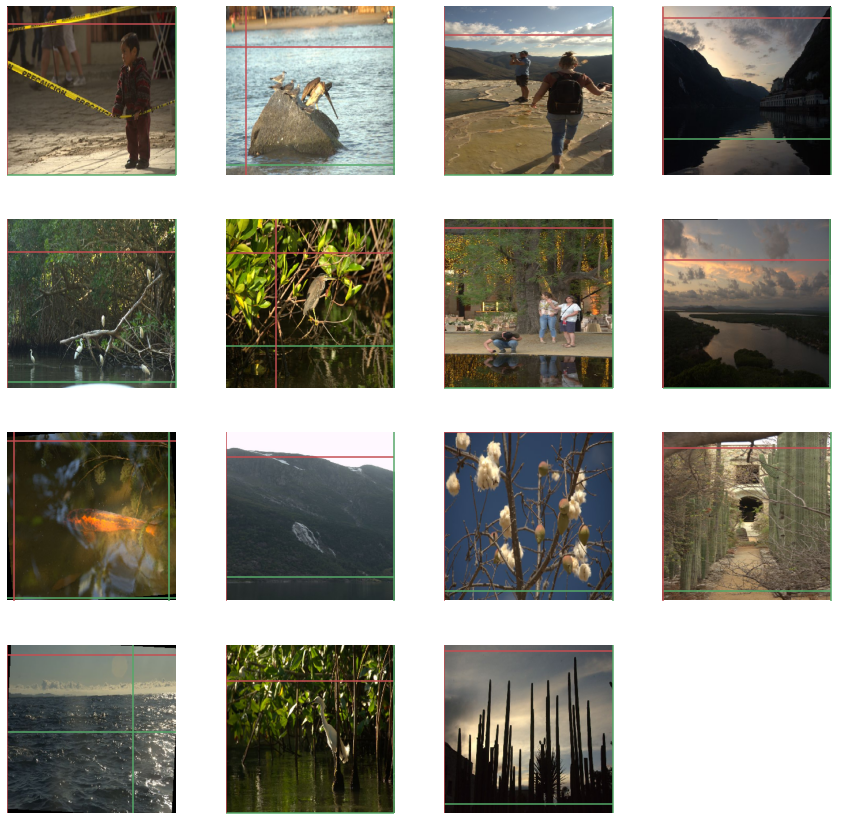

In [24]:
# Show a sample batch from the training set:
image_batch, label_batch = train_data_gen.__getitem__(0)
put.show_batch(image_batch, label_batch, f=val_shift_inv)

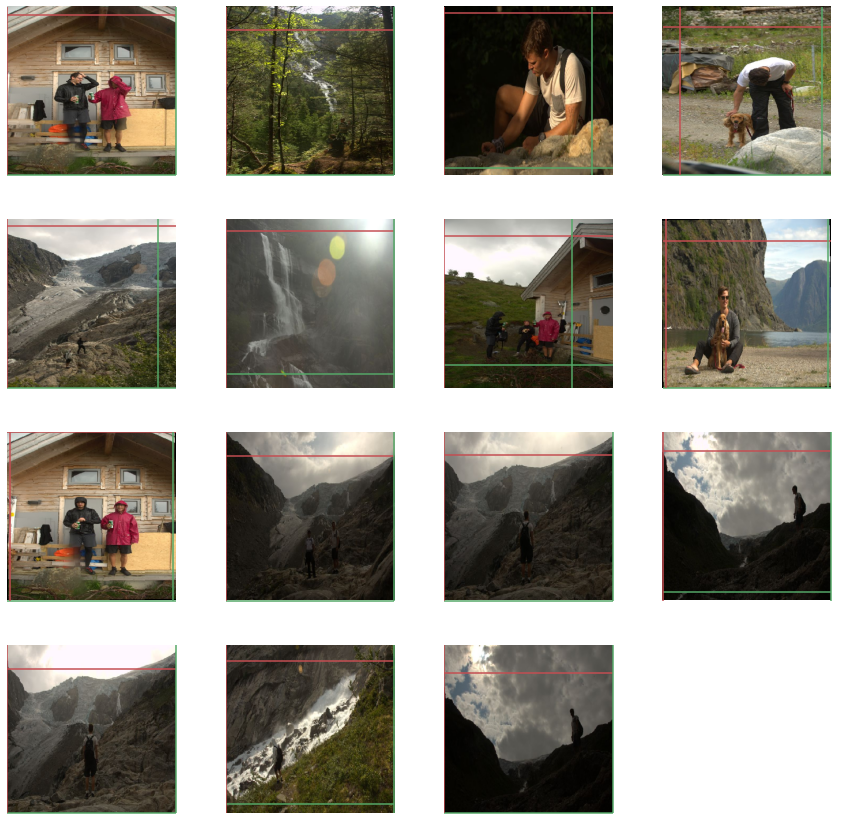

In [25]:
# Show a sample batch from the validation set:
image_batch, label_batch = eval_data_gen.__getitem__(0)
put.show_batch(image_batch, label_batch, f=val_shift_inv)

---

## 4. Define the model

In [26]:
from tensorflow.keras import datasets, layers, models
import datetime
from keras import backend as BK
import keras

In [27]:
from keras.constraints import NonNeg, MinMaxNorm

In [28]:
import custom_tf_modules as cus
cus = reload(cus)

In [29]:
MODEL_TAG = 'NonAugmented_smaller_LR'
SET_TAG = 'reborn'

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1, noise_shape=None, seed=None))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1, noise_shape=None, seed=None))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (1, 1), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5))

In [31]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0


---

## 5. Train the model

In [32]:
import tensorboard_utils as tbu
tbu = reload(tbu)

try:
    model_name_prev
except NameError:
    model_name_prev = ""

In [33]:
EPOCHS = 60
STEPS_PER_EPOCH=len(train_data_gen)

In [34]:
model_name_prev

''

In [35]:
# Create model name based on the tag and no. epochs
model_name = f'{MODEL_TAG}_e{EPOCHS}'

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(dir_cp,model_name,"cp-{epoch:04d}.ckpt")
if not os.path.isdir(os.path.join(dir_cp,model_name)):
    os.makedirs(os.path.join(dir_cp,model_name))
    
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5)


log_dir = "logs\\"+SET_TAG+"\\" + MODEL_TAG
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

print("Copy&paste the following to command line to launch tensorboard:")
print("tensorboard --logdir", log_dir)
print()

# Display images on the training on the tensorboard:
# Optionally completely unseen data:
_, tb_img = put.prep_dir(dir_eval, IMG_HEIGHT, IMG_WIDTH)

im_callback = tbu.TensorBoardImage(
    image_batch=(tb_img[:9], None), 
    image_dir=dir_train,
    log_dir=log_dir, f=val_shift_inv
)


Copy&paste the following to command line to launch tensorboard:
tensorboard --logdir logs\reborn\NonAugmented_smaller_LR

Creating grid of: 3


In [36]:
if model_name_prev == model_name:
    print("Using same model name? Type 'yes' to continue")
    ans = input()
    if ans != "yes":
        raise Exception("Not starting with same name")
        
history = model.fit(
    train_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=eval_data_gen,
    validation_steps=5,
    callbacks=[tb_callback, im_callback, cp_callback]
)

# Save the model:
model.save(os.path.join(dir_save, model_name+'.h5')) 
model_name_prev = model_name

Epoch 1/60
 3/16 [====>.........................] - ETA: 17s - loss: 0.8261 - accuracy: 0.2667

KeyboardInterrupt: 

---
## 6. Test on some unseen data:

### 6.1 Optionally load a model ( do not run this if you just want to test the trained)

In [37]:
# Optionally load a model:
model_selector = widgets.Dropdown(
    options=glob.glob(dir_save+'*.h5'),
    description='Model:',
    disabled=False,
)
display(model_selector)

Dropdown(description='Model:', options=('models\\Augmented_e15.h5', 'models\\Custom_Loss_BN_e60.h5', 'models\\…

In [38]:
# Load the selected model
model = models.load_model(model_selector.value, custom_objects={
    'Within': cus.Within, 
    'WeightClip': cus.WeightClip,
    'custom_loss': cus.custom_loss
})


### 6.2. Run the model

In [39]:
# The input shape for the model:
_, H, W, C = model.layers[0].input_shape
tags, imgs = put.prep_dir(dir_eval, H, W)
pred = model.predict(imgs)

In [40]:
pred_df = pd.DataFrame(data=pred, columns=["CropBottom", "CropLeft", "CropTop", "CropRight", "CropAngle"])

## 6.3. Inspect the results
First, lets see how the model predicts the evaluation images and how the distributions of the said predictions look like:

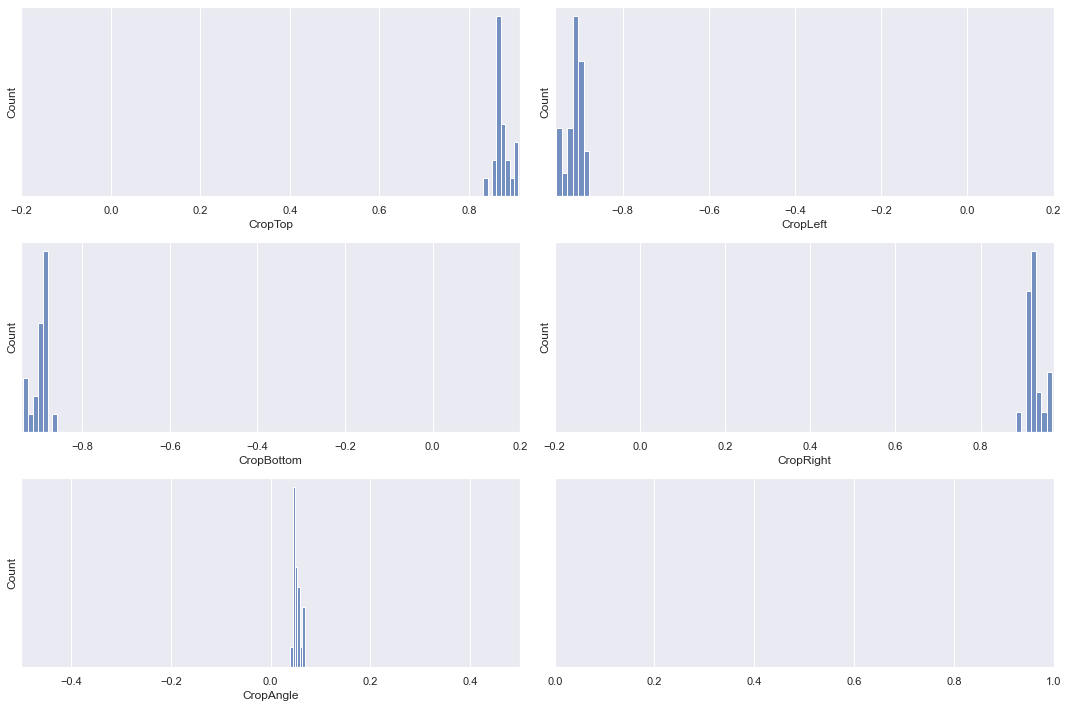

In [41]:
sns.set_theme(style="darkgrid")
f, axes = plt.subplots(3, 2)
# sns.despine(left=True)

sns.histplot(pred_df, x="CropTop", ax=axes[0, 0]), axes[0, 0].set_xlim(-0.2, None)
sns.histplot(pred_df, x="CropLeft", ax=axes[0, 1]), axes[0, 1].set_xlim(None, 0.2)
sns.histplot(pred_df, x="CropBottom", ax=axes[1, 0]), axes[1, 0].set_xlim(None, 0.2)
sns.histplot(pred_df,  x="CropRight", ax=axes[1, 1]), axes[1, 1].set_xlim(-0.2, None)
sns.histplot(pred_df,  x="CropAngle", ax=axes[2, 0]), axes[2, 0].set_xlim(-0.5, 0.5)

plt.setp(axes, yticks=[])
plt.tight_layout()

Show all the reuslts in a grid:

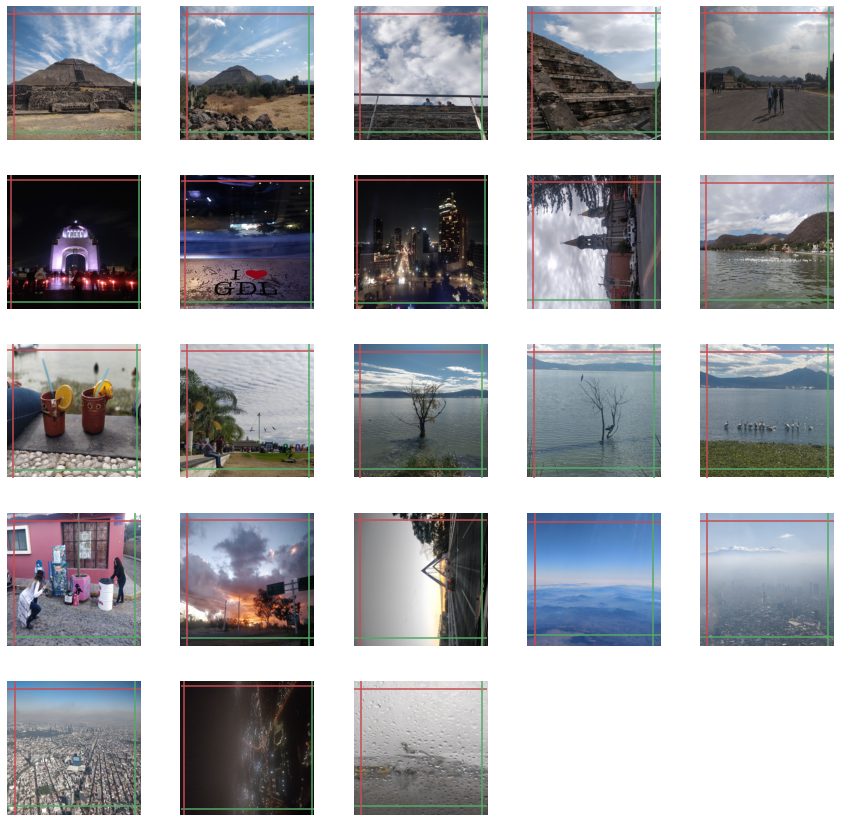

In [42]:
put.show_batch(imgs, pred, f=val_shift_inv)

Loop through bigger individual photos

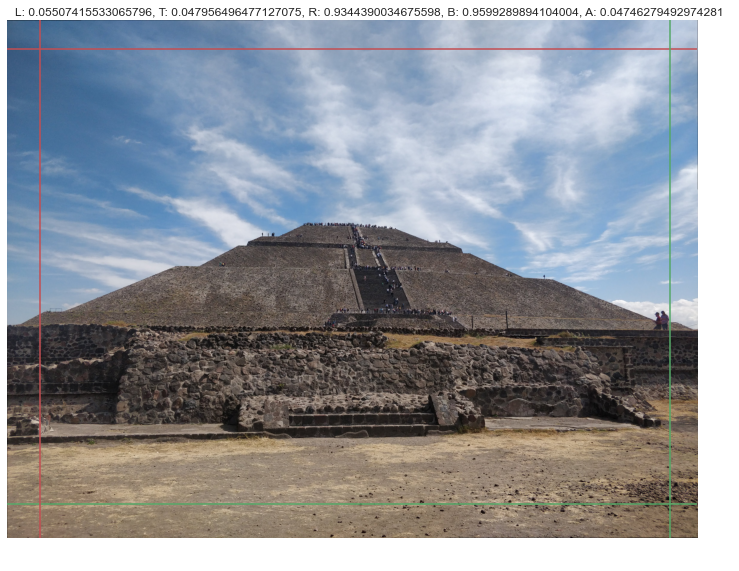

Type anything and press return to quit: h


In [45]:
for n in range(len(pred)):
    put.show_single(tags[n], pred[n], f=val_shift_inv)
    ans = input("Type anything and press return to quit: ")
    if ans:
        break

    displayer.clear_output(wait=True)
    display(plt.gcf())